# LRCN for image captioning:

LRCN stands for Long-term Recurrent Convolutional Network. It is a type of neural network that combines a convolutional neural network (CNN) with a recurrent neural network (RNN) to generate descriptions or captions for images. The CNN is used to extract features from the images, and the RNN is used to generate a sequence of words that describe the image based on the features extracted by the CNN.

LRCN can be trained end-to-end using backpropagation to minimize a loss function that measures the difference between the generated captions and the ground-truth captions. It has been widely used in image captioning tasks and has shown promising results in generating descriptive captions that capture the main objects and attributes in the image.

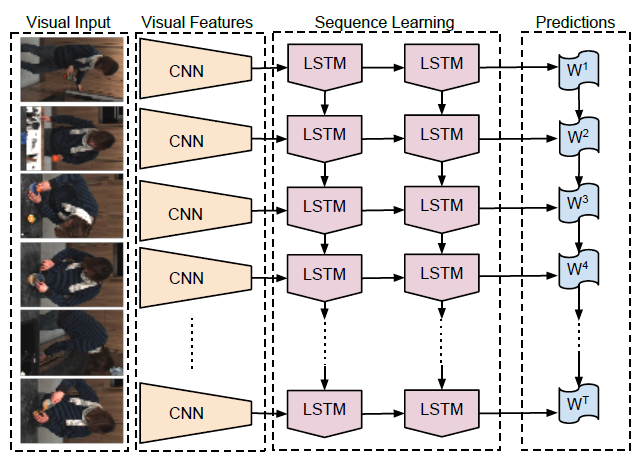

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
import os
import nltk
from nltk.tokenize import word_tokenize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running On...:', device)

Running On...: cuda


## Data:

The Flickr dataset was created by a team of researchers at the University of Illinois at Urbana-Champaign, including Tamara Berg, Alexander Berg, and Jia Deng. The dataset was released in 2010 as part of a research paper titled "Building and Using a Semantically Annotated Image Dataset" presented at the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Since then, the dataset has become a widely-used benchmark for image captioning and related tasks in the field of computer vision. It is a popular image captioning dataset used for training and evaluating image captioning models. It consists of 8,000 images or 30000 images, depending on the version from the Flickr website, each with five captions written by different people. The dataset was originally released in 2010 and has since become a widely-used benchmark for image captioning research. The images in the Flickr dataset cover a wide range of topics and are of varying quality, with some images being heavily edited or filtered. The captions are generally descriptive in nature and often include details about the objects and activities depicted in the image. The Flickr dataset is commonly used in combination with a pre-trained image recognition model such as ResNet or Inception to build a joint image recognition and captioning model such as the LRCN model. The dataset can also be used for other tasks such as object detection or image retrieval.
We use the data from: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [2]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, vocab=None, max_caption_len=30):
        """
        Args:
            root_dir (string): Directory with all the images.
            captions_file (string): CSV file with image filenames and their captions.
            transform (callable, optional): Optional transform to be applied on a sample.
            vocab (dict): Optional vocabulary dictionary with word to index mappings.
            max_caption_len (int): Maximum length of captions. Captions exceeding this length will be truncated.
        """
        self.root_dir = root_dir
        self.captions_frame = pd.read_csv(captions_file)
        self.transform = transform
        self.max_caption_len = max_caption_len
        
        # Create vocabulary if not provided
        if vocab is None:
            self.vocab = self.create_vocab(self.captions_frame['caption'].tolist())
        else:
            self.vocab = vocab
            
    def __len__(self):
        return len(self.captions_frame)
    
    def __getitem__(self, idx):
        img_name = self.captions_frame.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        caption = self.captions_frame.iloc[idx, 1]
        caption_tokens = word_tokenize(caption.lower())
        caption_tokens = caption_tokens[:self.max_caption_len] # truncate captions exceeding the max length
        caption_encoded = [self.vocab.get(token, self.vocab['<unk>']) for token in caption_tokens] # replace out-of-vocab words with '<unk>' token
        
        # Pad captions to the same length
        caption_len = len(caption_encoded)
        caption_encoded += [self.vocab['<pad>']] * (self.max_caption_len - caption_len)
        
        return image, torch.tensor(caption_encoded)
        
    def create_vocab(self, captions):
        """
        Create a vocabulary dictionary with word to index mappings for a list of captions.
        """
        vocab = {'<pad>': 0, '<unk>': 1} # reserve 0 for padding, 1 for out-of-vocab words
        index = 2 # start at 2 to reserve 0 and 1
        for caption in captions:
            tokens = word_tokenize(caption.lower())
            for token in tokens:
                if token not in vocab:
                    vocab[token] = index
                    index += 1
                    
        return vocab

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# Define the paths to the dataset and the captions file
data_path = "Data/flickr8/Images"
captions_file = "Data/flickr8/captions.txt"

# Load the dataset
flickr_dataset = FlickrDataset(data_path, captions_file, transform=transform)


# Define the size of the train, validation, and test sets
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(flickr_dataset, [train_size, val_size, test_size])

# Create the dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model:

Here, the ResNet-50 model is loaded with pretrained weights, and the final classification layer is removed. The last fully connected layer is replaced with a linear layer for embedding. The LSTM layer takes in the embeddings and generates output at each timestep. Finally, the output is passed through a linear layer to get the predicted captions. Note that the init_weights() method is used to initialize the weights of the embedding and output layers. The input to the model is a batch of images and captions, where the images are passed through the ResNet-50 backbone to generate image features, and the captions are passed through the LSTM. The image features and captions are then concatenated, and the final output is generated by passing the final hidden state of the LSTM through a linear layer.

In [4]:

class LRCN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, resnet_pretrained=True):
        """
        Args:
            vocab_size (int): Size of the vocabulary.
            embed_size (int): Size of the word embeddings.
            hidden_size (int): Size of the LSTM hidden states.
            num_layers (int): Number of layers in the LSTM.
            resnet_pretrained (bool): Whether to use a pre-trained ResNet50 as the image encoder.
        """
        super(LRCN, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Use pre-trained ResNet50 as the image encoder
        self.resnet = models.resnet50(pretrained=resnet_pretrained)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        
    def forward(self, images, captions):
        """
        Args:
            images (tensor): Tensor of images with shape (batch_size, channels, height, width).
            captions (tensor): Tensor of captions with shape (batch_size, caption_length).
        """
        # Image Encoder
        features = self.resnet(images)
        features = features.unsqueeze(1) # Add sequence length of 1
        
        # Caption Decoder
        embeddings = self.embed(captions[:,:-1])
        embeddings = torch.cat((features, embeddings), dim=1)
        lstm_out, _ = self.lstm(embeddings)
        outputs = self.linear(lstm_out)
        
        return outputs

In this model, we use a pre-trained ResNet-50 model to extract features from images, and pass them along with embedded captions through an LSTM network. The LSTM network is followed by a linear layer to get scores over the vocabulary, which are returned as the output. We also use a dropout layer to reduce overfitting.

## Train:

In [5]:
# set hyperparameters
num_epochs = 5
learning_rate = 0.001
hidden_size = 512
vocab_size = 15000
num_layers = 1


In [27]:
# Initialize the model
model = LRCN(vocab_size,
             batch_size, 
             hidden_size, 
             num_layers).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # Set the model to train mode
    model.train()
    
    # Loop over the training set
    for (images, captions) in tqdm(train_loader):
        # Move images and captions to the device
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, captions[:, :-1])
        targets = captions[:, 1:].reshape(-1)
        loss = criterion(outputs.view(-1, outputs.shape[2]), targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Add the batch loss to the total loss for the epoch
        train_loss += loss.item()
        
    # Set the model to eval mode
    model.eval()
    
    # Disable gradient computation for validation
    with torch.no_grad():
        # Loop over the validation set
        for (images, captions) in tqdm(val_loader):
            # Move images and captions to the device
            images = images.to(device)
            
            captions = captions.to(device)
            
            # Forward pass
            outputs = model(images, captions[:, :-1])
            targets = captions[:, 1:].reshape(-1)
            loss = criterion(outputs.view(-1, outputs.shape[2]), targets)
            
            # Add the batch loss to the total loss for the epoch
            val_loss += loss.item()
    
    # Compute the average losses for the epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Print the epoch number and the average losses
    print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, num_epochs, train_loss, val_loss))

# Save the model
torch.save(model.state_dict(), "lrcn_resnet50_flickr8k.pth")

100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.31it/s]


Epoch [1/5], Train Loss: 1.9836, Val Loss: 1.7889


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.25it/s]


Epoch [2/5], Train Loss: 1.7260, Val Loss: 1.7058


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.31it/s]


Epoch [3/5], Train Loss: 1.6192, Val Loss: 1.6644


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.21it/s]


Epoch [4/5], Train Loss: 1.5305, Val Loss: 1.6512


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [00:20<00:00, 12.22it/s]

Epoch [5/5], Train Loss: 1.4452, Val Loss: 1.6528


## Results and Discussion:
Long-term Recurrent Convolutional Networks (LRCNs) are a hybrid architecture that combines Convolutional Neural Networks (CNNs) with Recurrent Neural Networks (RNNs) to perform tasks on sequences of images. LRCNs are primarily used in applications such as video analysis, image captioning, and action recognition.

The LRCN architecture has several strengths. First, the convolutional component of the model allows it to extract robust features from images, making it effective at recognizing complex patterns in image sequences. Second, the recurrent component of the model enables it to capture temporal dependencies between frames in a video or sequence of images, which is crucial for tasks like video analysis and captioning. Third, the use of pre-trained CNNs as the image feature extractor can significantly reduce the training time required for the model. However, LRCNs also have some limitations. One major issue is that they are computationally expensive, especially when training on large datasets. Another limitation is that the use of pre-trained CNNs can limit the model's ability to learn unique features from the input data, as the pre-trained weights may not be well-suited to the specific task at hand. Additionally, the architecture can be difficult to optimize, as the combination of convolutional and recurrent layers can lead to vanishing gradients during backpropagation. In conclusion, LRCNs offer a powerful approach for analyzing sequences of images and videos, but they also have some limitations that should be considered when designing and training models. As with any machine learning approach, careful consideration of the task at hand, the available data, and the computational resources available is necessary to ensure the best possible results.